# **Predictive Maintenance with Pump Sensor data**

In this notebook we are going to try and train a classifier to predict the state of a pump based on the sensors output. We have selected Logistic Regression as our classifier. Since the results for classification seemed too good to be true, we also tried oversampling and test-validation-train methods alongside usual test-train workflow.
 

## **Import Libraries** 
Like usual, we start with importing the libraries we need, and add additional libraries as we progress through the notebook here.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm

%matplotlib inline

## Import the Data
The data is downloaded from Kaggle.com, in form of a CSV file. Therefore, we are using pandas to import the data into Python.

In [60]:
df = pd.read_csv("sensor.csv", sep=',' , header = 0, index_col=0)
df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


By checking the distribution of the label categories, we can see the data is very imbalanced.

In [62]:
df.groupby('machine_status').agg({'machine_status':'count'})

,machine_status
machine_status,
BROKEN,7
NORMAL,205836
RECOVERING,14477


## Indexing the label categories
We are going to categories the machine states to Normal as 0, and Recovering or Broken as 1.

In [61]:
df['label'] = df['machine_status'].apply(lambda x: 1 if x =='NORMAL' else 0)

df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status,label
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL,1
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL,1
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL,1
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL,1
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL,1


## Cleaning the Data
Checking the number of missing values in our sensor data, we can see how Sensor_15 is an entirly empty column.

In [63]:
df.isna().sum()

timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16
sensor_38             27


In [5]:
df = df.drop(['sensor_15', 'sensor_50'], axis=1)
df = df.dropna()

In [6]:
df.groupby('machine_status').agg({'label':'count'})

,label
machine_status,
BROKEN,6
NORMAL,192769
RECOVERING,3040


In [7]:
label = np.array(df['label'])
Features = np.array(df.iloc[:,1:51])

## Spliting the data into test and train subsets

In [8]:
nr.seed(123)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 0.25 )
X_train = Features[indx[0],:]
Y_train = np.ravel(label[indx[0]])
X_test = Features[indx[1],:]
Y_test = np.ravel(label[indx[1]])

## Scaling the features 

In [9]:
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Training the Logistic Regression model

In [10]:
logistic_mod = linear_model.LogisticRegression(class_weight = {0:99, 1:1}, max_iter=1000)
logistic_mod.fit(X_train, Y_train)

predictions = logistic_mod.predict(X_test)
score = logistic_mod.score(X_test, Y_test)

print(score)

0.995403848510847


## Defining a custom function to show Confusion Matrix and other metrics

In [12]:
probabilities = logistic_mod.predict_proba(X_test)
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)


def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])


    
print_metrics(Y_test, scores)    

                 Confusion matrix
                 Score positive    Score negative
Actual positive       757                 1
Actual negative       224             47972

Accuracy  1.00
 
           Positive      Negative
Num case      758         48196
Precision    0.77          1.00
Recall       1.00          1.00
F1           0.87          1.00


## Defining a custom function for ploting the ROC and showing AUC

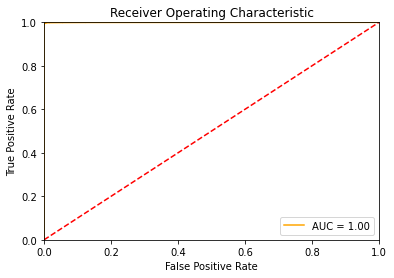

In [13]:
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(Y_test, probabilities)   

## Synthetic Minority Oversampling Technique

In [14]:
import imblearn
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=23, sampling_strategy=1)
X_train_sm, Y_train_sm = sm.fit_resample(X_train, Y_train)

X_test_sm, Y_test_sm = sm.fit_resample(X_test, Y_test)

len(X_test_sm)

## Running the Logistic Regression with the oversampled data

                 Confusion matrix
                 Score positive    Score negative
Actual positive     48162                34
Actual negative       194             48002

Accuracy  1.00
 
           Positive      Negative
Num case    48196         48196
Precision    1.00          1.00
Recall       1.00          1.00
F1           1.00          1.00


C:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


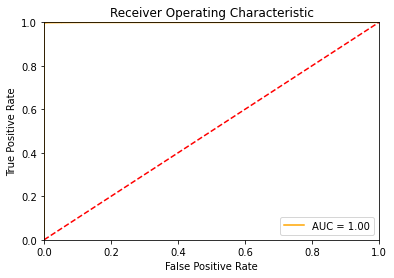

In [16]:
logistic_mod = linear_model.LogisticRegression( max_iter=100)
logistic_mod.fit(X_train_sm, Y_train_sm)

predictions = logistic_mod.predict(X_test_sm)
score = logistic_mod.score(X_test_sm, Y_test_sm)

probabilities = logistic_mod.predict_proba(X_test_sm)
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)

print_metrics(Y_test_sm, scores)    
plot_auc(Y_test_sm, probabilities)   

## Running Logistic Regression with Train, Validation and Test Data

In [46]:
label = np.array(df['label'])
Features = np.array(df.iloc[:,1:51])

nr.seed(123)
X_train, X_test, Y_train, Y_test = ms.train_test_split(Features, label, test_size=0.2)
X_train, X_val, Y_train, Y_val = ms.train_test_split(X_train, Y_train, test_size=0.25)


scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Running the model on Validation Data

In [53]:
logistic_mod = linear_model.LogisticRegression(class_weight = {0:99, 1:1}, max_iter=1000)
logistic_mod.fit(X_train, Y_train)

predictions = logistic_mod.predict(X_val)
score = logistic_mod.score(X_val, Y_val)

print(score)

0.995659168092332


## Resutls of  model on Validation data

                 Confusion matrix
                 Score positive    Score negative
Actual positive       618                 1
Actual negative       169             38375

Accuracy  1.00
 
           Positive      Negative
Num case      619         38544
Precision    0.79          1.00
Recall       1.00          1.00
F1           0.88          1.00


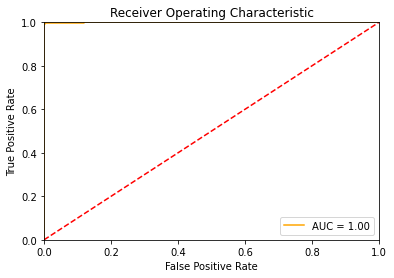

In [54]:
probabilities = logistic_mod.predict_proba(X_val)
scores = score_model(probabilities, 0.5)
print_metrics(Y_val, scores) 
plot_auc(Y_val, probabilities)    

## Running the model on Test data

In [57]:
logistic_mod = linear_model.LogisticRegression(class_weight = {0:99, 1:1}, max_iter=1000)
logistic_mod.fit(X_train, Y_train)

predictions = logistic_mod.predict(X_test)
score = logistic_mod.score(X_test, Y_test)
print(score)

0.9955059622602968


                 Confusion matrix
                 Score positive    Score negative
Actual positive       607                 1
Actual negative       175             38380

Accuracy  1.00
 
           Positive      Negative
Num case      608         38555
Precision    0.78          1.00
Recall       1.00          1.00
F1           0.87          1.00


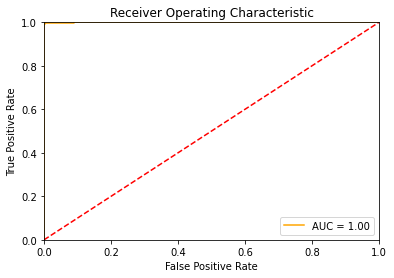

In [56]:
probabilities = logistic_mod.predict_proba(X_test)
scores = score_model(probabilities, 0.5)
print_metrics(Y_test, scores) 
plot_auc(Y_test, probabilities)    